In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv('C:\\Users\\micro\\Downloads\\Compressed\\archive\\OnlineRetail.csv', encoding='ISO-8859-1')

In [5]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# check if colunm has null

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#drop the nulls otherwise it deppend if we want to fill it with something or just drop nulls

In [15]:
df.dropna(inplace = True)

#change the date datatype from object to datetime

In [10]:
df['InvoiceDate'] =pd.to_datetime(df['InvoiceDate'])

In [17]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#check for duplictes i have many dupicates but instead of drop it we can just get latest order by customer 
#drop it is not a best solution bcz maybe a customer make many order and we need to keep it 

In [24]:
df.duplicated().sum()

np.int64(5225)

In [ ]:
#create connection with database for better analysis

In [25]:
from sqlalchemy import create_engine
import urllib

connection_string = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=HP-ELITEBOOK\\SQLEXPRESS;"
    "DATABASE=practice;"
    "Trusted_Connection=yes;"
)

engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % connection_string)

In [26]:
conn= engine.connect()
conn
df.to_sql('retail_data',con =conn,index= False ,if_exists='replace')
q = lambda sql: pd.read_sql(sql, engine)#create a function to so we dont need to run long query


In [ ]:
#only get latest order to remove duplicates

In [162]:
df1=q('''
select * from(
select 
[invoiceNo],
[stockCode],
[description],
ABS([quantity]) as [quantity],
[invoiceDate],
[unitPrice],
abs([quantity])*[unitprice] as [Total_price],
[customerId],
[country],
row_number() over(partition by [customerid],[Description] order by [invoicedate] desc) as ranking
from retail_data)t where [ranking] = 1
''')
df1.head(2)

,invoiceNo,stockCode,description,quantity,invoiceDate,unitPrice,Total_price,customerId,country,ranking
0,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:17:00,1.04,77183.6,12346.0,United Kingdom,1
1,573511,84558A,3D DOG PICTURE PLAYING CARDS,36,2011-10-31 12:25:00,2.95,106.2,12347.0,Iceland,1


#some descriptive statistics 

In [163]:
df1[['quantity','unitPrice','Total_price']].describe()

,quantity,unitPrice,Total_price
count,269081.000000,269081.000000,269081.000000
mean,12.101884,3.259810,19.918260
std,216.942831,78.721736,370.156905
min,1.000000,0.000000,0.000000
25%,2.000000,1.060000,4.950000
50%,6.000000,1.690000,11.700000
75%,12.000000,3.750000,17.850000
max,80995.000000,38970.000000,168469.600000


In [62]:
#total price or total revenue

In [164]:
df1['Total_price'].sum()

np.float64(5359625.443)

In [ ]:
#expected average by total_revenue

In [165]:
df1['Total_price'].mean()

np.float64(19.9182604606048)

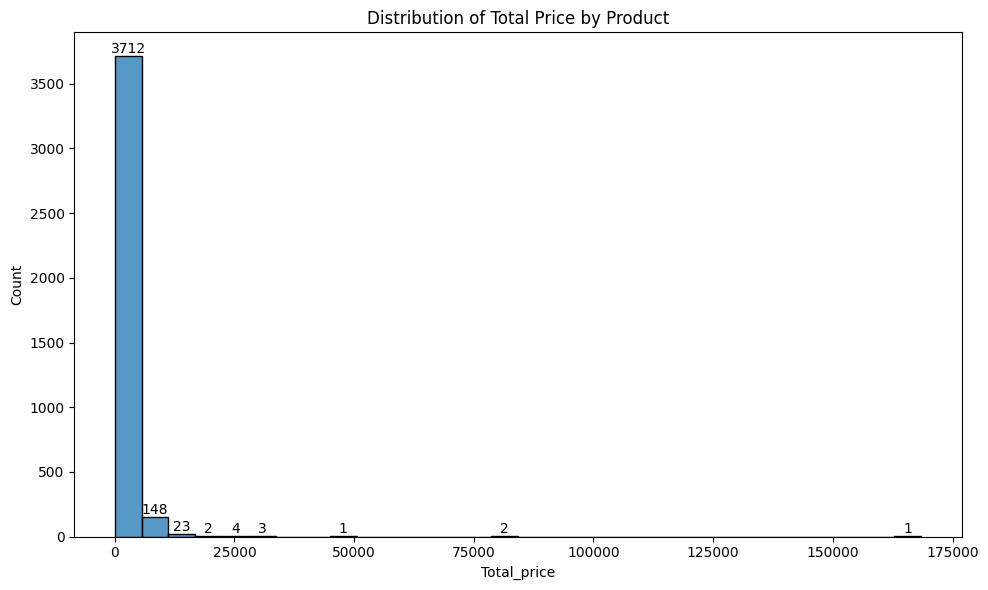

In [166]:
data1 = df1.groupby('description')['Total_price'].sum().reset_index(name='Total_price')

plt.figure(figsize=(10, 6))
ax = sns.histplot(x='Total_price', data=data1, bins=30)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )

plt.title('Distribution of Total Price by Product')
plt.tight_layout()
plt.show()

In [ ]:
#show higest purchase products

C:\Users\micro\AppData\Local\Temp\ipykernel_15228\2886701307.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='description', y='Total_price', data=group_data, palette='Set2', legend=False)


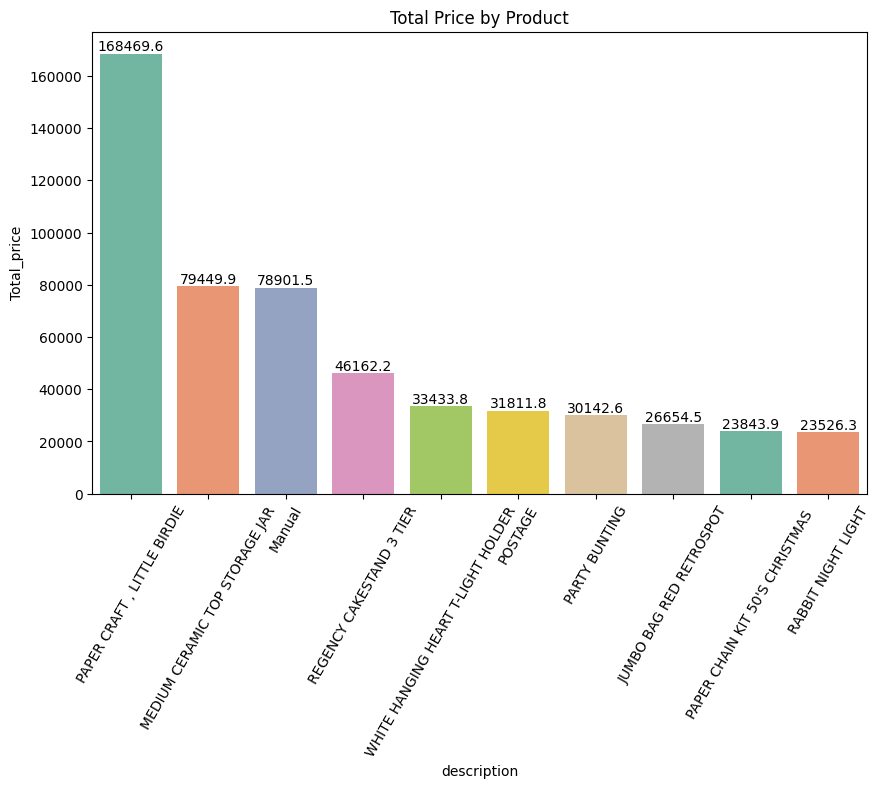

In [167]:
group_data = (
    df1.groupby('description')['Total_price']
    .sum()
    .nlargest(10)
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='description', y='Total_price', data=group_data, palette='Set2', legend=False)

for i in ax.containers:
    ax.bar_label(i, fmt='%.1f')

plt.xticks(rotation=60)
plt.title('Total Price by Product')
plt.show()

In [168]:
df_daily = df1.groupby('invoiceDate')['Total_price'].sum().reset_index()
df_daily

,invoiceDate,Total_price
0,2010-12-01 08:34:00,140.33
1,2010-12-01 08:45:00,313.70
2,2010-12-01 09:32:00,165.60
3,2010-12-01 09:37:00,198.78
4,2010-12-01 09:41:00,31.65
...,...,...
18214,2011-12-09 12:23:00,58.00
18215,2011-12-09 12:25:00,140.64
18216,2011-12-09 12:31:00,329.05
18217,2011-12-09 12:49:00,339.20


In [ ]:
#line chart that show price over time

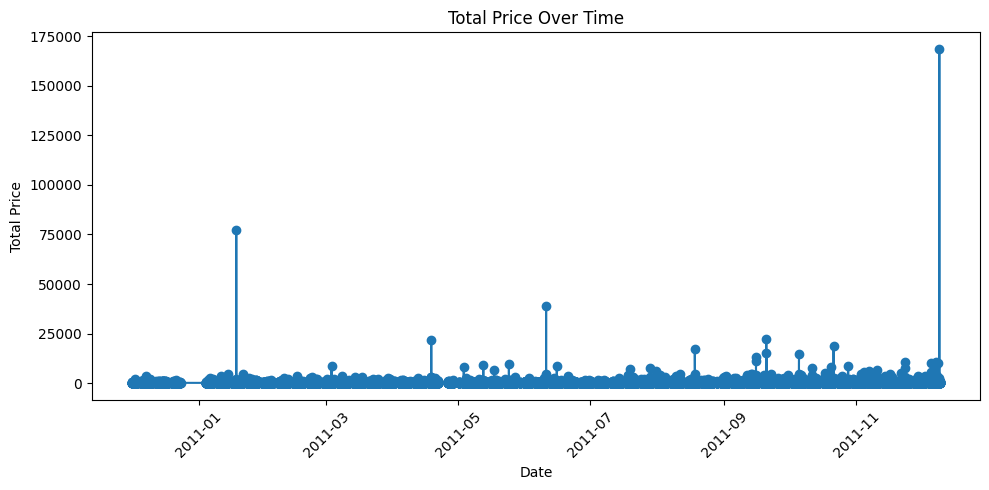

In [169]:


plt.figure(figsize=(10, 5))
plt.plot(df_daily['invoiceDate'], df_daily['Total_price'], marker='o', linestyle='-')
plt.title('Total Price Over Time')
plt.xlabel('Date')
plt.ylabel('Total Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#create new table for clean data

In [ ]:
from sqlalchemy import text

with engine.connect() as conn:
    conn.execute(text('''
        CREATE TABLE retail_order_summery (
            [invoiceNO] NVARCHAR(50),
            [stockCode] NVARCHAR(50),
            [description] NVARCHAR(100),
            [quantity] INT,
            [invoiceDate] DATETIME,
            [unit_price] FLOAT,
            [total_sale] FLOAT,
            [ranking] INT
        )
    '''))

In [ ]:
#insert clean data into new table

In [171]:
df2 =df1.to_sql(name='retail_order_summery',con= engine, 
           if_exists='replace',  # repend to existing table
         index=False  )
df2

98

In [ ]:
#moving average

In [172]:
df3=q('''select 
       [Total_price],
      avg([Total_price]) OVER (partition by [customerId] ORDER BY [invoiceDate] ROWS BETWEEN 2 PRECEDING AND CURRENT ROW)
      from retail_order_summery''')
df3.head(10)

,Total_price,
0,77183.60,77183.60
1,17.40,17.40
2,55.80,36.60
3,37.50,36.90
4,22.50,38.60
5,15.00,25.00
6,32.94,23.48
7,15.00,20.98
8,39.00,28.98
9,15.00,23.00


In [ ]:
#use lag function that compare previous and present sales/simply how much we make it like we drop sales or up them

In [173]:
df3=q('''select 
       [Total_price],
       lag([Total_price],1) over(order by [invoiceDate]) as [comparision_of_sales]
      from retail_order_summery''')
df3.head(10)

,Total_price,comparision_of_sales
0,54.08,NaN
1,14.85,54.08
2,9.90,14.85
3,31.80,9.90
4,14.85,31.80
5,14.85,14.85
6,70.80,14.85
7,17.00,70.80
8,46.80,17.00
9,40.80,46.80


#highest score by country

C:\Users\micro\AppData\Local\Temp\ipykernel_15228\2028972285.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='country' , y = 'Total_price',palette = 'Set2',data = grp_data)


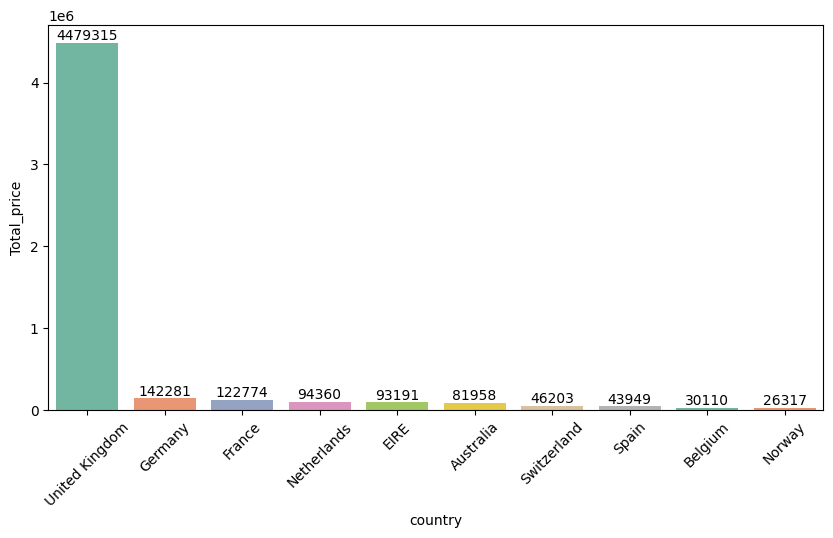

In [177]:
grp_data = df1.groupby('country')['Total_price'].sum().nlargest(10).reset_index()
plt.figure(figsize = (10,5))
ax = sns.barplot(x='country' , y = 'Total_price',palette = 'Set2',data = grp_data)
for i in ax.containers:
    ax.bar_label(i , fmt='%.0f')
plt.xticks(rotation=45)
plt.show()

In [178]:
df1.head(2)

,invoiceNo,stockCode,description,quantity,invoiceDate,unitPrice,Total_price,customerId,country,ranking
0,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:17:00,1.04,77183.6,12346.0,United Kingdom,1
1,573511,84558A,3D DOG PICTURE PLAYING CARDS,36,2011-10-31 12:25:00,2.95,106.2,12347.0,Iceland,1


In [ ]:
#relation betwwen quantity and total_sales

In [183]:
df1['quantity'].corr(df1['Total_price'])

np.float64(0.9131532656341558)

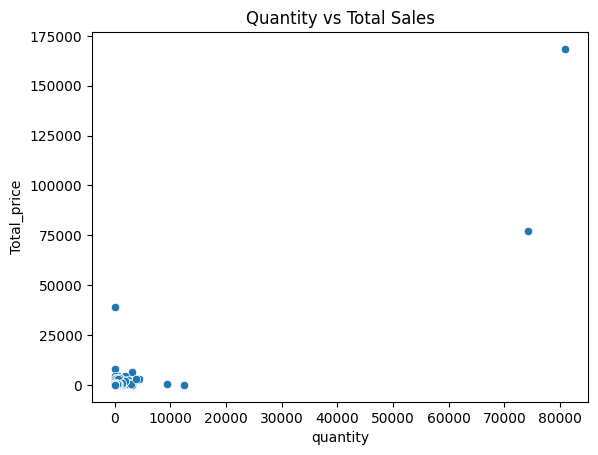

In [184]:
sns.scatterplot(x='quantity', y='Total_price', data=df1)
plt.title('Quantity vs Total Sales')
plt.show()